In [33]:
# utilities
import re
import numpy as np
import pandas as pd
# plotting
import seaborn as sns
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
# nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk import FreqDist
from nltk.stem import WordNetLemmatizer
import spacy
# sklearn
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report,f1_score

In [3]:
#!pip install -U wordcloud
#!pip install -U plotly plotly-express
#!pip install -U spacy
## for word embedding
!pip install -U gensim
# import gensim
# import gensim.downloader as gensim_api
# nlp = spacy.load('en_core_web_sm')

In [4]:
# Importing the training dataset
DATASET_COLUMNS=['id','label','tweet']
df_train = pd.read_csv('https://raw.githubusercontent.com/prateekjoshi565/twitter_sentiment_analysis/master/train_E6oV3lV.csv', names=DATASET_COLUMNS, header=0)
df_train.sample(5)

,id,label,tweet
10138,10139,0,nothing like celebrating bihdays with old frie...
27465,27466,0,@user wow! 100 of you have followed us in jus...
6464,6465,0,"""the wrecking crew doing what we do best"" #smi..."
13014,13015,0,first day of my summer nursing placements tomo...
242,243,0,make today count! #mondaymotivation #livelifet...


In [5]:
#Length of the dataset

print('length of train data is', len(df_train))
df_train.describe()

length of train data is 31962


,id,label
count,31962.000000,31962.000000
mean,15981.500000,0.070146
std,9226.778988,0.255397
min,1.000000,0.000000
25%,7991.250000,0.000000
50%,15981.500000,0.000000
75%,23971.750000,0.000000
max,31962.000000,1.000000


In [6]:
# Importing the Testing dataset
DATASET_COLUMNS=['id','tweet']
df_test = pd.read_csv('https://raw.githubusercontent.com/prateekjoshi565/twitter_sentiment_analysis/master/test_tweets_anuFYb8.csv', names=DATASET_COLUMNS,header=0)
df_test.sample(5)

,id,tweet
5116,37079,"eh, mr dj on @user scotland just now. wind you..."
12693,44656,india lost to zimbabwe in t20. #zimvind
3362,35325,@user non stop #biher for 8 years
14128,46091,still #trudging the #road to #destiny
12684,44647,why @user my bags used to show up before the 1...


In [7]:
#Length of the dataset

print('length of test data is', len(df_test))

length of test data is 17197


In [8]:
#Check the number of target values
df_train['label'].unique()

array([0, 1], dtype=int64)

<AxesSubplot:xlabel='label', ylabel='count'>

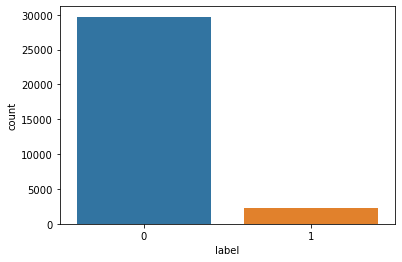

In [9]:
# Plotting the distribution for dataset.
#px.box(df_train, x="label", y="tweet", color="label", title="Distribution of tweets for each label")
sns.countplot(x='label', data=df_train)
# Storing data in lists.
#text, sentiment = list(df_train['tweet']), list(df_train['label'])

In [10]:
fig = px.pie(df_train, names=df_train.label, hole=0.7, title='Tweets Classification',
             height=250, color_discrete_sequence=px.colors.qualitative.T10)
fig.update_layout(margin=dict(t=100, b=40, l=60, r=40), 
                  plot_bgcolor='#2d3035', paper_bgcolor='#2d3035',
                  title_font=dict(size=25, color='#a5a7ab', family="Lato, sans-serif"),
                  font=dict(color='#8a8d93'),
                  )
fig.show()

#### Word Count per Label

In [43]:
df_train['word_counts'] = df_train['tweet'].str.split().str.len()
df_train.groupby('label')['word_counts'].mean()

label
0    13.091252
1    14.053078
Name: word_counts, dtype: float64

## Data Preprocesing

In [11]:
# Remove @user from the twwet
def remove_pattern(input_txt):
    r = re.findall(r"@(\w+)", input_txt)
    for i in r:
        input_txt = re.sub(f'@{i}', '', input_txt)      
    return input_txt
df_train['clean_tweet'] = df_train['tweet'].apply(lambda x: remove_pattern(x))
df_train.tail()

,id,label,tweet,clean_tweet
31957,31958,0,ate @user isz that youuu?ðððððð...,ate isz that youuu?ððððððð...
31958,31959,0,to see nina turner on the airwaves trying to...,to see nina turner on the airwaves trying to...
31959,31960,0,listening to sad songs on a monday morning otw...,listening to sad songs on a monday morning otw...
31960,31961,1,"@user #sikh #temple vandalised in in #calgary,...","#sikh #temple vandalised in in #calgary, #wso..."
31961,31962,0,thank you @user for you follow,thank you for you follow


In [12]:
#remove_pattern('@user when a father is dysfunctional and his son is a good')
df_train['tweet'][df_train['label'] == 0][:10]

0     @user when a father is dysfunctional and is s...
1    @user @user thanks for #lyft credit i can't us...
2                                  bihday your majesty
3    #model   i love u take with u all the time in ...
4               factsguide: society now    #motivation
5    [2/2] huge fan fare and big talking before the...
6     @user camping tomorrow @user @user @user @use...
7    the next school year is the year for exams.ð...
8    we won!!! love the land!!! #allin #cavs #champ...
9     @user @user welcome here !  i'm   it's so #gr...
Name: tweet, dtype: object

In [13]:
hashtags = []
def hashtag_extract(x):
    # Loop over the words in the tweet
    for i in x:
        ht = re.findall(r"#(\w+)", i)
        hashtags.append(ht)
    return hashtags

# extracting hashtags from neg/pos tweets
dff_0 = hashtag_extract(df_train['clean_tweet'][df_train['label'] == 0])
dff_1 = hashtag_extract(df_train['clean_tweet'][df_train['label'] == 1])
dff_all = hashtag_extract(df_train['clean_tweet'][df_train['label']])
# unnesting list
dff_0 = sum(dff_0,[])
dff_1 = sum(dff_1,[])
dff_all = sum(dff_all,[])

data_0 = FreqDist(dff_0)
data_0 = pd.DataFrame({'Hashtag': list(data_0.keys()),
                  'Count': list(data_0.values())}).sort_values(by='Count', ascending=False)
data_0[:5]

,Hashtag,Count
0,run,29753
3,getthanked,2244
1,lyft,2244
2,disapointed,2243
33,love,1542


In [14]:
fig = px.bar(data_0[:30], x='Hashtag', y='Count', height=250,
             title='Top 30 hashtags',
             color_discrete_sequence=px.colors.qualitative.T10)
fig.update_yaxes(showgrid=False),
fig.update_xaxes(categoryorder='total descending')
fig.update_traces(hovertemplate=None)
fig.update_layout(margin=dict(t=100, b=0, l=60, r=40), 
                  hovermode="x unified",
                  xaxis_tickangle=300,
                  xaxis_title=' ', yaxis_title=" ",
                  plot_bgcolor='#2d3035', paper_bgcolor='#2d3035',
                  title_font=dict(size=25, color='#a5a7ab', family="Lato, sans-serif"),
                  font=dict(color='#8a8d93')
                  )
fig.show()

In [15]:
#!pip install tweet-preprocessor
import preprocessor as p
def preprocess_tweet(row):
    text = row['clean_tweet']
    text = p.clean(text)
    return text

def preprocessing_text(text):
     # Make lowercase
     text = text.str.lower()
     # Remove punctuation
     text = text.str.replace('[^\w\s]', '', regex=True)
     # Remove digits
     text = text.str.replace('[\d]+', '', regex=True)
     return text
pd.set_option('max_colwidth', 500)

df_train['clean_tweet'] = df_train.apply(preprocess_tweet, axis=1)
df_train['clean_tweet'] = preprocessing_text(df_train['clean_tweet'])
df_train.head()

,id,label,tweet,clean_tweet
0,1,0,@user when a father is dysfunctional and is so selfish he drags his kids into his dysfunction. #run,when a father is dysfunctional and is so selfish he drags his kids into his dysfunction
1,2,0,@user @user thanks for #lyft credit i can't use cause they don't offer wheelchair vans in pdx. #disapointed #getthanked,thanks for credit i cant use cause they dont offer wheelchair vans in pdx
2,3,0,bihday your majesty,bihday your majesty
3,4,0,#model i love u take with u all the time in urð±!!! ðððð ð¦ð¦ð¦,i love u take with u all the time in ur
4,5,0,factsguide: society now #motivation,factsguide society now


In [16]:
# Removing Stopwords
STOPWORDS = stopwords.words('english')

def cleaning_stopwords(text,STOPWORDS):
    return " ".join([word for word in str(text).split() if word not in STOPWORDS])
df_train['clean_tweet'] = df_train['clean_tweet'].apply(lambda text: cleaning_stopwords(text,STOPWORDS))
df_train['clean_tweet'].head()

0            father dysfunctional selfish drags kids dysfunction
1    thanks credit cant use cause dont offer wheelchair vans pdx
2                                                 bihday majesty
3                                          love u take u time ur
4                                             factsguide society
Name: clean_tweet, dtype: object

In [17]:
a = df_train['clean_tweet'].str.cat(sep=' ')
words = word_tokenize(a)
word_dist = FreqDist(words)
dff = pd.DataFrame(word_dist.most_common(), 
                    columns=['Word', 'Frequency'])
dff['Word_Count'] = dff.Word.apply(len)
dff[:5]

,Word,Frequency,Word_Count
0,day,2042,3
1,amp,1615,3
2,happy,1576,5
3,love,1206,4
4,im,1149,2


In [18]:
fig = px.histogram(dff[:20], x='Word', y='Frequency', height=300, 
                   title='Most common 20 words in tweets', color_discrete_sequence=px.colors.qualitative.T10)
fig.update_yaxes(showgrid=False),
fig.update_xaxes(categoryorder='total descending')
fig.update_traces(hovertemplate=None)
fig.update_layout(margin=dict(t=100, b=0, l=70, r=40),
                        hovermode="x unified",
                        xaxis_tickangle=360,
                        xaxis_title=' ', yaxis_title=" ",
                        plot_bgcolor='#2d3035', paper_bgcolor='#2d3035',
                        title_font=dict(size=25, color='#a5a7ab', family="Lato, sans-serif"),
                        font=dict(color='#8a8d93'),
                          )
fig.show()

In [19]:
fig = px.bar(dff.tail(10), x='Word', y='Frequency', height=300, 
                   title='Least common 10 words in tweets', color_discrete_sequence=px.colors.qualitative.T10)
fig.update_yaxes(showgrid=False),
fig.update_xaxes(categoryorder='total descending')
fig.update_traces(hovertemplate=None)
fig.update_layout(margin=dict(t=100, b=0, l=70, r=40),
                        hovermode="x unified",
                        xaxis_title=' ', yaxis_title=" ",
                        plot_bgcolor='#2d3035', paper_bgcolor='#2d3035',
                        title_font=dict(size=25, color='#a5a7ab', family="Lato, sans-serif"),
                        font=dict(color='#8a8d93'),
                          )

## Sentiment Analysis

In [20]:
#Cleaning and removing Punctuations
# import string
# english_punctuations = string.punctuation
# punctuations_list = english_punctuations
# def cleaning_punctuations(text):
#     translator = str.maketrans('', '', punctuations_list)
#     return text.translate(translator)
# df_train['tweet']= df_train['tweet'].apply(lambda x: cleaning_punctuations(x))
# df_train['tweet'].tail()

In [21]:
#Cleaning and removing repeating characters
# def cleaning_repeating_char(text):
#     return re.sub(r'(.)1+', r'1', text)
# df_train['tweet'] = df_train['tweet'].apply(lambda x: cleaning_repeating_char(x))
# df_train['tweet'].tail()

In [22]:
#Cleaning and removing URL’s
# def cleaning_URLs(data):
#     return re.sub('((www.[^s]+)|(https?://[^s]+))',' ',data)
# df_train['tweet'] = df_train['tweet'].apply(lambda x: cleaning_URLs(x))
# df_train['tweet'].tail()

In [23]:
#Cleaning and removing Numeric numbers
# def cleaning_numbers(data):
#     return re.sub('[0-9]+', '', data)
# df_train['tweet'] = df_train['tweet'].apply(lambda x: cleaning_numbers(x))
# df_train['tweet'].tail()

In [24]:
from nltk.tokenize import RegexpTokenizer
from nltk import pos_tag,download
from collections import Counter
tokenizer = RegexpTokenizer(r'\w+')
df_train['token_tweet'] = df_train['clean_tweet'].apply(tokenizer.tokenize)
df_train['postag_tweet'] = df_train['token_tweet'].apply(lambda x: pos_tag(x))


In [25]:
counts = Counter( tag for df_train['token_tweet'].iloc[1],  tag in df_train['postag_tweet'].iloc[1])
print(counts,df_train['tweet'].iloc[1])
df_train.head()

Counter({'NN': 6, 'NNS': 2, 'VBP': 2}) @user @user thanks for #lyft credit i can't use cause they don't offer wheelchair vans in pdx.    #disapointed #getthanked


D:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,id,label,tweet,clean_tweet,token_tweet,postag_tweet
0,1,0,@user when a father is dysfunctional and is so selfish he drags his kids into his dysfunction. #run,father dysfunctional selfish drags kids dysfunction,"[father, dysfunctional, selfish, drags, kids, dysfunction]","[(father, RBR), (dysfunctional, JJ), (selfish, JJ), (drags, NNS), (kids, NNS), (dysfunction, NN)]"
1,2,0,@user @user thanks for #lyft credit i can't use cause they don't offer wheelchair vans in pdx. #disapointed #getthanked,thanks credit cant use cause dont offer wheelchair vans pdx,pdx,"[(thanks, NNS), (credit, NN), (cant, NN), (use, NN), (cause, NN), (dont, NN), (offer, VBP), (wheelchair, NN), (vans, NNS), (pdx, VBP)]"
2,3,0,bihday your majesty,bihday majesty,"[bihday, majesty]","[(bihday, NN), (majesty, NN)]"
3,4,0,#model i love u take with u all the time in urð±!!! ðððð ð¦ð¦ð¦,love u take u time ur,"[love, u, take, u, time, ur]","[(love, VB), (u, JJ), (take, VB), (u, JJ), (time, NN), (ur, JJ)]"
4,5,0,factsguide: society now #motivation,factsguide society,"[factsguide, society]","[(factsguide, RB), (society, NN)]"


#### Words in overall tweets

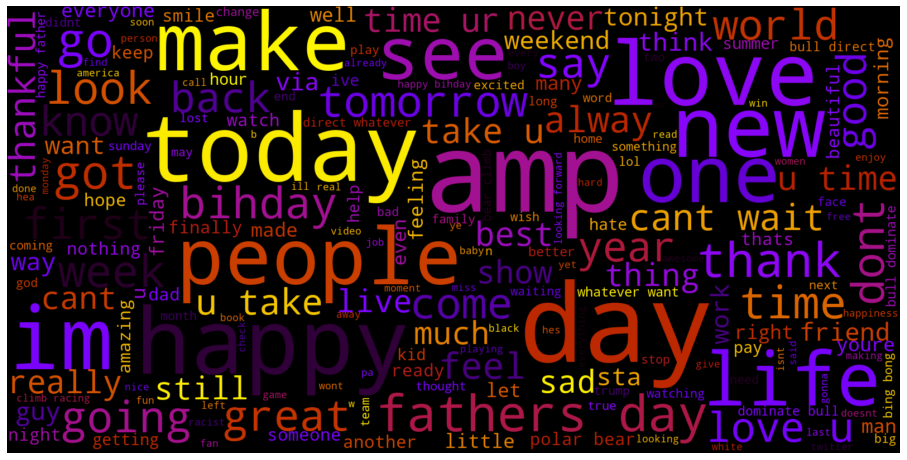

In [29]:
neg_string = []
for t in df_train.clean_tweet:
    neg_string.append(t)
neg_string = pd.Series(neg_string).str.cat(sep=' ')
from wordcloud import WordCloud

wordcloud = WordCloud(width=1600, height=800,max_font_size=200,colormap="gnuplot").generate(neg_string)
plt.figure(figsize=(16,12))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

#### “Words in non racist/sexist tweets”

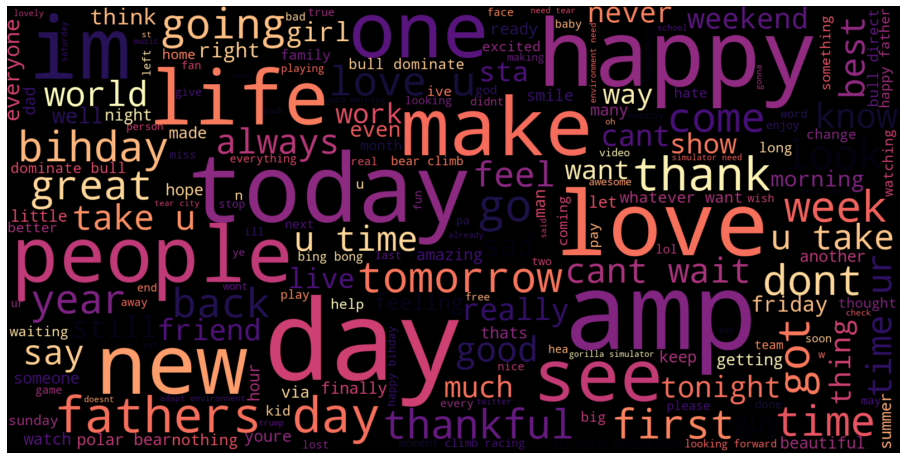

In [31]:
#“Words in non racist/sexist tweets”
neg_tweets = df_train[df_train['label'] == 0]
neg_string = []
for t in neg_tweets.clean_tweet:
    neg_string.append(t)
neg_string = pd.Series(neg_string).str.cat(sep=' ')
from wordcloud import WordCloud

wordcloud = WordCloud(width=1600, height=800,max_font_size=200,colormap="magma").generate(neg_string)
plt.figure(figsize=(16,12))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

#### “Words in racist/sexist tweets”

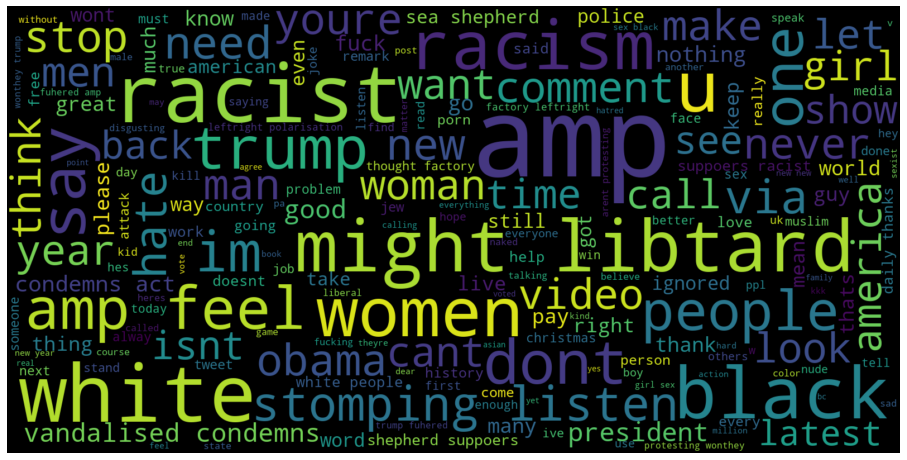

In [32]:
## Negative words
neg_tweets = df_train[df_train['label'] == 1]
neg_string = []
for t in neg_tweets.clean_tweet:
    neg_string.append(t)
neg_string = pd.Series(neg_string).str.cat(sep=' ')
from wordcloud import WordCloud

wordcloud = WordCloud(width=1600, height=800,max_font_size=200).generate(neg_string)
plt.figure(figsize=(16,12))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [47]:
#Bag of words
cvec = CountVectorizer()
cvec.fit(df_train.clean_tweet)
neg_doc_matrix = cvec.transform(df_train[df_train.label == 0].clean_tweet)
pos_doc_matrix = cvec.transform(df_train[df_train.label == 1].clean_tweet)
neg_tf = np.sum(neg_doc_matrix,axis=0)
pos_tf = np.sum(pos_doc_matrix,axis=0)
neg = np.squeeze(np.asarray(neg_tf))
pos = np.squeeze(np.asarray(pos_tf))
term_freq_df = pd.DataFrame([neg,pos],columns=cvec.get_feature_names()).transpose()
print(len(cvec.get_feature_names()))
term_freq_df.sample(10)

22634


,0,1
belief,4,1
aud,1,0
pentecost,1,0
curry,12,0
demands,1,0
hesitation,1,0
values,5,2
beater,1,0
audio,3,0
coooooooooool,1,0


In [49]:
#TF-IDF 
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(df_train.clean_tweet)
print(X.toarray())
print(len(vectorizer.get_feature_names()))

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
22634
